# Twitter Text Analysis

#### October 7th, 2022

In [2]:
#!pip install tweepy
#!pip install wordcloud
#!pip install textblob
#import TwitterCollector
from TwitterCollector import TwitterCollector

# we will use this later to specify the collection time window
from datetime import datetime

import time
import json     
from pprint import pprint 
import nltk
import pickle
import matplotlib.pyplot as plt
import pandas as pd  
import numpy as np
from collections import Counter
%matplotlib inline 
from wordcloud import WordCloud
from textblob import TextBlob

With the interest of analyzing how individuals express their opinions on social media, the purpose of this project is to conduct a Twitter analysis using Python. Our group picked a movie from Marvel Studio called Deadpool 3 as our general direction.

Around a week ago (at the end of September), Deadpool's main actor, Ryan Reynolds, posted a promotional video to share some updates on the upcoming Deadpool 3. As Marvel fans, we are interested in analyzing how individuals express themselves on Deadpool 3 on Twitter. Therefore, we specified our keyword of interest being ‘deadpool3’ to collect 10K recent tweets from Twitter. We did a preliminary analysis on the data to understand what possible topics are related to ‘deadpool3’, then created a data visualization using word clouds to help us visualize these related topics. In order to understand what the audiences’ perspectives are, we conducted a sentiment analysis to define whether Marvel’s audiences have positive or negative perspectives on Deadpool 3 based on what they posted on Twitter. 


### A.	Keyword Selection and Data Collection 

We acquired the unique bearer token from Twitter Developer, and initialized the TwitterCollector instance with the token.

In [ ]:
# fill in the bearer token
bearer_token = r"AAAAAAAAAAAAAAAAAAAAAPEWhwEAAAAA003V7rrDap%2BB%2FDMcGkfrrChTlfQ%3D49FLQf8J5yCU0lMoTgatGZhfL82KDb9WltSXzaG0wG04ri2aAE"

# initialize a TwitterCollector instance
tc = TwitterCollector(bearer_token = bearer_token)

#### 1.	Pick "deadpool3" as our interested keyword.

Our group picked the word ‘deadpool3’ based on group interest. Also because there were many trending discussions on this keyword recently. In order to collect the most accurate and readable data, we specified our keywords being ‘deadpool3’, written in english, and excluded from retweets on our search query.

In [ ]:
query1 = 'deadpool3 -is:retweet lang:en'  # tweets containing 'queen', written in English, and excluding retweets

#### 2.	[tweet data] Collect 10K recent tweets on the selected keyword.

We specified the query based on our selected keyword, and chose 10k tweets to meet the requirement, as well as adjustment on how we wanted the file to be saved. We modified the start time and end time, as TwitterCollector API only allows us to fetch the most recent 7 days of data. Then saved in the `code` folder with name `ac_data.json`.

In [ ]:
recent_tweets = tc.fetch_recent_tweets(query = query1  # specify the search query
                                        , tweets_cnt = 10000  # specify the number of tweets you want to collect
                                        , save_result = True  # if True, the tweets will be automatically saved to a json file apart from the value returned
                                        , start_time = datetime.fromisoformat('2022-09-27 00:00:00')  # starting time for tweet collection, must be within 7 days
                                        , end_time = datetime.fromisoformat('2022-10-03 12:00:00')  # ending time for tweet collection, must be within 7 days
                                        , save_dir = 'code'
                                        , file_name = 'ac_data.json'
                                        )

In [ ]:
# Check: do we have enough tweets
len(recent_tweets['tweets']) 

#### 3.	From the collected tweets, get the list of unique author IDs.

By creating 3 lists, we wanted to save author IDs as `author_id`, author information as `author_info`, and some other information that we might need to handle due to errors as `need_to_handle`. We used a for loop to iterate all the IDs from our dataset and fetch through all the IDs we got. 

However, TwitterCollector API would not allow us to fetch 10k of data at once. After fetching a certain amount of data, the system would crash and showed a *429 error as 'TooManyRequests'*; such error would result in the termination of the collection process and fail to collect the author information in that specific iteration. To deal with this error, we added the author id in the failing iteration to the `need_to_handle` list when we encountered the *TooManyRequests* error or any other errors;this allows us to keep track of them and fetch the author information later. For each time the error occurred, it required 15 minutes to cool down by Twitter, so we manually asked the program to have a 15-minute rest before continuing.

Note: The code below was inpired by Yi-Hsuan Chen with some editions. 

In [ ]:
#fetching author information through their ids
#inspired by Yi-Hsuan Chen's code from Piazza
author_id=[]
author_info = []
need_to_handle = []
for i in recent_tweets['tweets']:
    author_id =author_id + [i['author_id']]

for i in author_id:
    try:
        author_info.append(tc.fetch_author_info(i))
    except tweepy.TooManyRequests:
        print('TooManyRequests')
        print(i)
        need_to_handle.append(i)
        time.sleep(15*60)
    except:
        print('something else')
        need_to_handle.append(i)

In [ ]:
# Check: Do we collect enough author info
len(author_info)

In [ ]:
#Check how many ids we need to handle again
len(need_to_handle)

In [ ]:
#Check if the author info are well collected
author_info

As mentioned above, we did receive an error in our process, we put the rest of data that have not went through in to our `need_to_handle` list, and stored them with other correct data in our `author_info list`. 

We also added `except` part here to check whether we still met the *TooManyRequests* error this time. If we meet the error again, we need to append the current author infomation into `need_to_handle` again and fetch them into `author_info` list later.

In [ ]:
#kernal interupted due to crash, but did fetch 35 objects in need_to_handle list and stored them in author_info
for i in need_to_handle:
    try:
        author_info.append(tc.fetch_author_info(i))
    except tweepy.TooManyRequests:
        print('TooManyRequests')
        print(i)
        need_to_handle.append(i)
        time.sleep(15*60)

#### 4.	[author data] Collect the author information of those author IDs.

We double-checked the length of the `author_info` list and found that we were missing the last auther ID's information. Therefore we fetched the author information of the missing author ID then appended the additional information to `author_info` list. After completing collecting all the authors' information, we stored the information to a json fiel in order to keep the record and make it easier for further analysis.

In [ ]:
len(author_info)

In [ ]:
#We found we only have 1 missing author info, so we get this author's id
author_id[-1]

In [ ]:
#append this author information to our big list
author_info.append(tc.fetch_author_info('1566904942471913478'))

In [ ]:
#save our author info to a json file
info_file = open('author_info.json', 'w', encoding = 'utf-8')
json.dump(author_info,info_file)
info_file.close()

After collecting data from Twitter, We then loaded the information we stored in the json file and continued our analysis

In [3]:
#load the information for the following analysis
with open('author_info.json', 'r', encoding = 'utf-8') as file:
    check = json.load(file)

In [4]:
#check if we have all data we needed and the type of this json file
print(len(check))
type(check)

10000


list

In [5]:
unique_author_id = []
for i in check:
    if i['id'] not in unique_author_id:
        unique_author_id.append(i['id'])

In [6]:
len(unique_author_id)

7689

Since some authors had more than one posts on our selected keyword, we constructed a new list `unique_author` to collect the unique authors information.

**Notice:**   
We assume that authors with the same ID are the same author, in other words, even when their account description or amount of followers have changed, as long as they have the same author ID, we treat them as the same person.

In [7]:
def get_info(id):
    info = []
    for i in check:
        if i['id'] == str(id):
            info.append(i)
    return info

In [8]:
#getting all the unique authors with their information
unique_author = []
for i in unique_author_id:
    unique_author.append(get_info(i))

In [9]:
#check how many authors are there and the first 5 authors' information
print(len(unique_author))
pprint(unique_author[:5])

7689
[[{'created_at': '2010-12-17T22:09:53.000Z',
   'description': 'Full Time Swiftie, Cat lover and tea drinker. Dreams come '
                  'true, Swiftie since 2009 forever and always 💙💛💜❤️🤍🖤💗🤎🧡',
   'id': '227815574',
   'location': 'tay follows',
   'name': 'Denise (Taylor’s Version) 🧣🧣🧣',
   'public_metrics': {'followers_count': 6574,
                      'following_count': 3820,
                      'listed_count': 20,
                      'tweet_count': 42560},
   'username': 'HairFlipsCats13',
   'verified': False}],
 [{'created_at': '2015-05-21T15:55:17.000Z',
   'description': 'Just waiting for life to happen...',
   'id': '3222465817',
   'name': 'Harshit Jain',
   'public_metrics': {'followers_count': 64,
                      'following_count': 473,
                      'listed_count': 0,
                      'tweet_count': 1179},
   'username': 'imjnharshit',
   'verified': False}],
 [{'created_at': '2020-10-14T06:09:59.000Z',
   'description': 'Artist',
   'id

### B.	Tweets Features

We named our information collected from Twitter API as `data`. By checking the keys of `data`, we are clear what keys we can call, and have a look at the tweets' structure.

In [10]:
# Load JSON: json_data
with open("ac_data.json") as json_file:
    data = json.load(json_file)       # name the json data as "data"

print(type(data))

<class 'dict'>


In [11]:
# see the data structure
data.keys()

dict_keys(['collection_type', 'collection_timestamp', 'query', 'tweet_cnt', 'tweets'])

In [12]:
print(type(data['tweets']))      #check type of data['tweets']
print(len(data['tweets']))       #how many tweets in our data

<class 'list'>
10000


In [13]:
#have a look at the first tweet
print(data['tweets'][0].keys())  
pprint(data['tweets'][0])        

dict_keys(['entities', 'public_metrics', 'text', 'created_at', 'possibly_sensitive', 'source', 'context_annotations', 'id', 'author_id', 'edit_history_tweet_ids', 'lang'])
{'author_id': '227815574',
 'context_annotations': [{'domain': {'description': 'Named people in the world '
                                                    'like Nelson Mandela',
                                     'id': '10',
                                     'name': 'Person'},
                          'entity': {'description': 'Taylor Swift',
                                     'id': '806225270591995904',
                                     'name': 'Taylor Swift'}},
                         {'domain': {'description': 'Categories within Brand '
                                                    'Verticals that narrow '
                                                    'down the scope of Brands',
                                     'id': '46',
                                     'name': 'Business Taxo

#### 1.	What are the ten most popular words with and without stop words?

   ##### a) ten most popular words with stop words:

First we created a list to store all words in text for all tweets we have collected, we used a for loop to get texts from all tweets, and splitted the text into single words. We used the extend method here to add the single words from the text to the end of the `words` list. Then we counted how many times each word appeared in our list, and chose the most common 10 words. 

The 10 most common words are : `#Deadpool3` appeared 8560 times, `the` appeared 3939 times, `to` appeared 2926 times, `in` appeared 2835 times, `#Wolverine` appeared 2448 times, `is` appeared 2302 times, `and` appeared 2238 times, `a` appeared 1972 times, `for` appeared 1871 times, and `I` appeared 1820 times.

In [14]:
words = []   # a list of all words in text for all tweets
for tweet in data['tweets']:
    txt = tweet['text']
    words.extend(txt.split())
Counter(words).most_common(10)

[('#Deadpool3', 8560),
 ('the', 3939),
 ('to', 2926),
 ('in', 2835),
 ('#Wolverine', 2448),
 ('is', 2302),
 ('and', 2238),
 ('a', 1972),
 ('for', 1871),
 ('I', 1820)]

After that, we used a plot to visualize the 10 most popular words based on their counts.

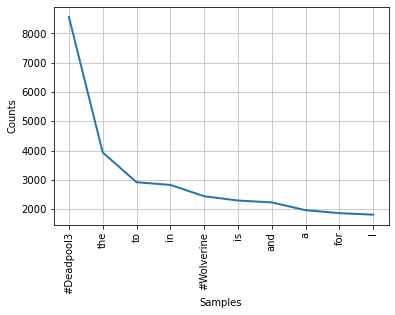

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [15]:
# get frequent words
freq = nltk.FreqDist(words)
freq.plot(10)

From the result above, we noticed the outcome we had so far included hashtags, which indicated that some hashtags appeared in the texts. In addition, we noticed that there were links in texts as well. Since the hashtags and links should not be considred as the "words", we would remove them from our `words` list in the following steps, and had a look at the new most common words from there.

We defined two functions to remove the hashtags and hyperlinks separately. We passed a list of words through function `words_hash_removal` to remove the hashtags in the list; and passed a list of words through function `words_link_removal` to remove the hyperlinks in the list.

 It is worth mentioning that, the words list might be used later, so we wanted to keep our original `words` list. We created a copy of our original words list, and removed the *hashtags(#)* and *hyperlinks(http)*  within the new copies. 

In [16]:
#Method for hash tag removal
def words_hash_removal(list_words):
    list = list_words.copy()
    for i in list_words:
        if '#' in i:
            list.remove(i)
    return list
#Method for hyperlink removal
def words_link_removal(list_words):
    list = list_words.copy()
    for i in list_words:
        if 'http' in i:
            list.remove(i)
    return list

We stored the result for words without hashtags as `words_no_hash`, and words without hashtages or hyperlinks as `words_no_h_l` for future use.

In [17]:
words_no_hash = words_hash_removal(words)
words_no_h_l = words_link_removal(words_no_hash)

We re-ranked the ten most popular words without hastags or hyperlinks based on the counts of how many times each word appeared, as well as visualized the result with a plot. 

The 10 most common words now are : `the` appeared 3939 times, `to` appeared 2926 times, `in` appeared 2835 times, `is` appeared 2302 times, `and` appeared 2238 times, `a` appeared 1972 times, `for` appeared 1871 times, `I` appeared 1820 times, `of` appeared 1595 times, `Hugh` appeared 1468 times.

In [18]:
Counter(words_no_h_l).most_common(10)

[('the', 3939),
 ('to', 2926),
 ('in', 2835),
 ('is', 2302),
 ('and', 2238),
 ('a', 1972),
 ('for', 1871),
 ('I', 1820),
 ('of', 1595),
 ('Hugh', 1468)]

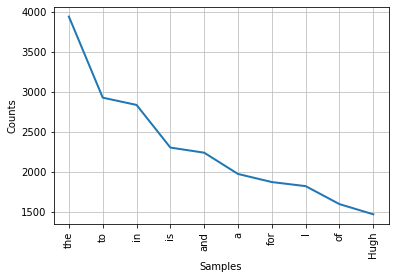

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
# get frequent words
freq_with_stop = nltk.FreqDist(words_no_h_l)
#plot the most freguent words
freq_with_stop.plot(10)

##### b) ten most popular words without stop words:

Since the stopwords make no sense in our analysis, we wanted to remove all stopwords in the following steps and get the most common words from rest.

For convenience, we loaded the `Stopwords` file used in class. After analysis we found that there were still some stopwords with capital letter appeared as most commons words in our results such as "The" and "This". So we wrote these words into the original `Stopwords` file, and record them as a new file `stopwords_new`.

In [20]:
#load stopwords
l = []
with open('stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)
    l+=(stopwords)
with open('stopwords_new.pkl', 'wb') as f:
    sw = ['The', 'This']
    l +=(sw)
    pickle.dump(l, f)
with open('stopwords_new.pkl', 'rb') as f:
    stopwords_new = pickle.load(f)

In [21]:
#check new stopwords
print(type(stopwords_new), len(stopwords_new), stopwords_new, sep="\n")

<class 'list'>
181
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sam

We created a new words list called `words_without` to contain the words without the stopwords.   

We used a for loop to iterate all the words and checked whether the word was in our new `stopwords` file. If it was not in the file, then we appended it to the `words_without` list.

In [22]:
words_without = [] # words list without stop words

for w in words_no_h_l:
    if w not in stopwords_new and len(w) > 1:
        words_without.append(w)

We ranked the ten most popular words without stopwords based on the counts of how many times each word appeared, as well as visualized the result with a plot.

The 10 most common words now are : `Hugh` appeared 1468 times, `@VancityReynolds` appeared 1396 times, `Deadpool` appeared 1389 times, `Wolverine` appeared 1352 times,  `Jackman` appeared 1115 times, `@RealHughJackman` appeared 1111 times, `Ryan` appeared 669 times, `back` appeared 555 times, `Reynolds` appeared 507 times, `&amp` appeared 477 times.

In [23]:
freq_without = nltk.FreqDist(words_without)
Counter(words_without).most_common(10)

[('Hugh', 1468),
 ('@VancityReynolds', 1396),
 ('Deadpool', 1389),
 ('Wolverine', 1352),
 ('Jackman', 1115),
 ('@RealHughJackman', 1111),
 ('Ryan', 669),
 ('back', 555),
 ('Reynolds', 507),
 ('&amp;', 477)]

common words without stop words


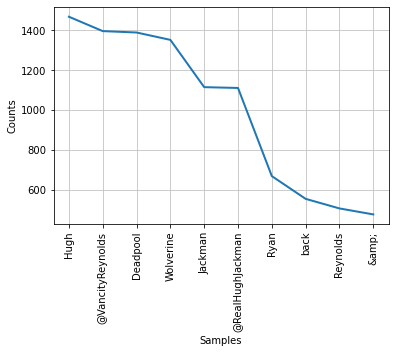

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [24]:
print('common words without stop words')
freq_without.plot(10)

#### 2.	What are the ten most popular hashtags (#hashtag)?

We defined a new method called `extract_hash` to extract all hashtags, by creating a new list named `l`, and using a for loop to append all the # with words from our `l` list. Thus, `l` was the list containing all the hashtags.

In [25]:
#define method that extracts all hashtag
def extract_hash(list):
    l = []
    for i in list:
        if '#' in i:
            l.append(i)
    return l

With the above method, we were able to find all the *hashtags(#)* in words and printed the first five to check the results.

In [26]:
#Extract all hashtags
hashtags = extract_hash(words)
print(hashtags[:5])
freq_hashtag = nltk.FreqDist(hashtags)

['#Deadpool3', '#Midnights', '#Deadpool3', '#Deadpool3', '#RyanReynolds']


We ranked the ten most popular hastags based on the counts, and visualize the result with a plot.

They are `#Deadpool3` appeared 8560 times, `#Wolverine` appeared 2448 times, `#HughJackman` appeared 1202 times, `#RyanReynolds` appeared 865 times, `#Deadpool` appeared 834 times, `#MarvelStudios` appeared 641 times, `#MCU` appeared 613 times, `#deadpool3` and `#NordStream2` appeared 579 times, `#Marvel` appeared 460 times.

In [27]:
Counter(hashtags).most_common(10)

[('#Deadpool3', 8560),
 ('#Wolverine', 2448),
 ('#HughJackman', 1202),
 ('#RyanReynolds', 865),
 ('#Deadpool', 834),
 ('#MarvelStudios', 641),
 ('#MCU', 613),
 ('#deadpool3', 579),
 ('#NordStream2', 579),
 ('#Marvel', 460)]

10 most hashtags


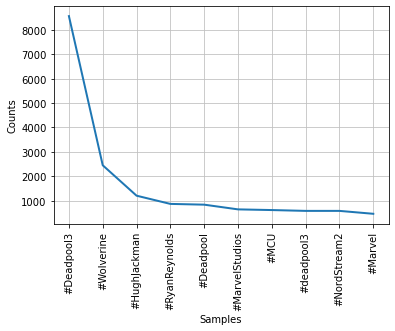

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [28]:
#Creating hastag line plots
print('10 most hashtags')
freq_hashtag.plot(10)

#### 3.	What are the ten most frequently mentioned usernames (@username)?

As Twitter usernames start with @, we first created a list of all mentioned users `mentionedUsers`. By using the for loop, we fetched through `words_no_h_l` which we created before to store words without hashtages or hyperlinks. We appended @ as an element in front of usernames to our list of all mentioned users, then ranked the ten most frequently mentioned usernames based on the counts of how many times each username appeared.

The 10 most common frequently mentioned usernames are : `VancityReynolds` appeared 1396 times, `RealHughJackman` appeared 1111 times, `MarvelStudios` appeared 201 times, `deadpoolmovie` appeared 132 times,  `YouTube` appeared 104 times, `Deadpool` appeared 78 times, `Marvel` appeared 69 times, `ShawnLevyDirect` appeared 66 times, `Kevfeige` appeared 63 times, `RyanReynolds` appeared 44 times.

In [29]:
mentionedUsers = []   #list of all mentioned users
for ele in words_no_h_l:
    if ele[0] == '@':
        mentionedUsers.append(ele[1:])
Counter(mentionedUsers).most_common(10)

[('VancityReynolds', 1396),
 ('RealHughJackman', 1111),
 ('MarvelStudios', 201),
 ('deadpoolmovie', 132),
 ('YouTube', 104),
 ('Deadpool', 78),
 ('Marvel', 69),
 ('ShawnLevyDirect', 66),
 ('Kevfeige', 63),
 ('RyanReynolds', 44)]

#### 4.	Which are the three most common sources of the tweets? A tweet’s source can be found in the “source” field in the tweet data.

We created a list of sources `sourceLst`, by using a for loop, we passed through all tweets in our dataset, then appeneded all the sources we found to the list of sources with the `append` function. With the `Counter` function, we ranked the 3 most common sources based on how many times they appeared in our list of sources. We found the most common source is Android, following with iPhone, and then Web App.

In [30]:
sourceLst = []   #list of sources
for i in data['tweets']:
    source = i['source']
    sourceLst.append(source)
Counter(sourceLst).most_common(3)

[('Twitter for Android', 3910),
 ('Twitter for iPhone', 3168),
 ('Twitter Web App', 2231)]

#### 5.	Create a line chart to show the time trend of tweet counts (number of tweets in a day (or an hour or a minute) depending on the collected data).

We created a list of dates and used a for loop to pass through all the tweets in our dataset to extract the date of each tweet created and used the `append` funtion to append the date of creation to list of dates `days`. Then we used the `unique` function to count the number of tweets post each unique day, and stored the count to each date in a tuple `day_vs_count`. Now we could create the line chart using the counts of each day as our y inputs versus the date of creation as our x inputs, then published the line chart by adjusting its xlabel and ylabel, as well as figure sizes.

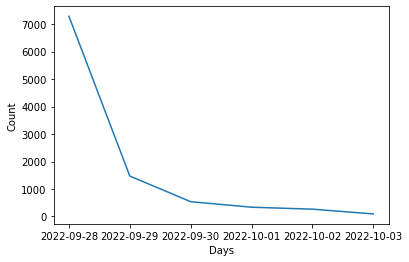

In [31]:
days = []    #list of dates
for tweet in data['tweets']:
    day = tweet['created_at']
    days.append(day[:10])
    
day_vs_count = np.unique(days, return_counts = True)   #counts of each day
plt.plot(day_vs_count[0],day_vs_count[1]) 
plt.xlabel("Days")
plt.ylabel("Count")
plt.rcParams["figure.figsize"] = (10,3)
plt.show()

Here we created another line chart with chaning the time gap to one hour instead of one day using the same method mentioned above.\
Due to high frequency on the x-axis, all the hour value were overlapping each other.

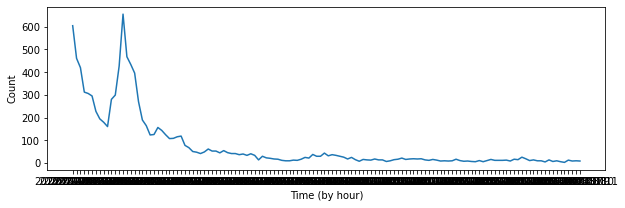

In [32]:
# time gap = 1h
hours = []    #list of hours
for tweet in data['tweets']:
    hour = tweet['created_at']
    hours.append(hour[:13])
    
hour_vs_count = np.unique(hours, return_counts = True)   #counts of each hour
plt.plot(hour_vs_count[0],hour_vs_count[1]) 
plt.xlabel("Time (by hour)")
plt.ylabel("Count")
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

#### 6.	Which are the three most influential tweets? A tweet’s influence score is the sum of “quote_count”, “reply_count”, “retweet_count”, “like_count”. These counts can be found in the “public_metrics” in the tweet data.

To find the most influential tweets, we wanted to make a data frame with a list of tweets called `tweets` and a list of influence scores `scoreLst`. Then we could rank the influence score within the data frame, and we could get the top three score and their coresponding tweets. 

Within the for loop, we iterated all tweets and sum up the tweet's `quote_count`, `reply_count`, `retweet_count` and `like_count` to get the influence scores, then appended the influence score to `scoreLst`. We appened the tweets into `tweets` list as well.

In [33]:
# get a list of influence scores and a list tweets
tweets = []   #list of tweets
scoreLst = [] #list of influence score
for tweet in data['tweets']:
    inf_score = sum(tweet['public_metrics'].values())
    scoreLst.append(inf_score)    # get a list of influence score named "inf_score"
    tweets.append(tweet)          # get a list of tweets named "tweets"

We stored the list of influences scores and the list of tweets together into `inf_data`, and made it as a data frame called `inf_df`. 

In [34]:
# dataset contains a list of influence scores and a list tweets
inf_data = {'Tweets':tweets, 'Influence Score':scoreLst}  
#construct a df using the dataset above
inf_df = pd.DataFrame(inf_data)

In [35]:
# show the dataframe
inf_df

,Tweets,Influence Score
0,"{'entities': {'hashtags': [{'start': 250, 'end...",0
1,"{'entities': {'hashtags': [{'start': 64, 'end'...",0
2,"{'entities': {'hashtags': [{'start': 79, 'end'...",0
3,"{'entities': {'hashtags': [{'start': 0, 'end':...",0
4,"{'entities': {'hashtags': [{'start': 105, 'end...",4
...,...,...
9995,{'attachments': {'media_keys': ['7_15749118831...,0
9996,"{'created_at': '2022-09-28T00:00:32.000Z', 'en...",2
9997,"{'created_at': '2022-09-28T00:00:19.000Z', 'en...",0
9998,"{'created_at': '2022-09-28T00:00:18.000Z', 'en...",4


We sorted tweets from our new data frame based on their influence score in a decending order, and got the three most influencial tweets with scores from the data frame.

In [36]:
# sort over influence score (high to low), and get the top three
sorted_inf = inf_df.sort_values(by=['Influence Score'], ascending=False)
top_three = sorted_inf[:3]
top_three

,Tweets,Influence Score
2357,"{'created_at': '2022-09-29T03:06:26.000Z', 'ed...",119325
4175,"{'entities': {'hashtags': [{'start': 37, 'end'...",77604
9547,"{'author_id': '1054013417210683398', 'entities...",73968


Once we got the index for the top three tweets, we could pass the indeces and got the texts.

In [37]:
# The most influential tweet
tweets[2357]['text']  

'Hugh Jackman is ready to play Wolverine again 🤘🐐 \n\n#Deadpool3  https://t.co/QshWGVmaej'

In [38]:
# The second most influential tweet:
tweets[4175]['text']

'BREAKING: Tom Holland’s Peter Parker/#SpiderMan will have a cameo in #Deadpool3! https://t.co/lHgbZOOSF6'

In [39]:
# The third influenctial tweet
tweets[9547]['text']

'It was right there all along. #Deadpool3 https://t.co/dOXhtICjfe'

#### 7.	Who are the three most vocal authors on the keyword? In other words, who are the most frequently tweeting authors in the tweet data? 

After creating the list of all authors `authorLst`, we used a for loop to get all author id from all tweets, and appended them into `authorLst`.

In [40]:
authorLst = [] 
for tweet in data['tweets']:
    author = tweet['author_id']
    authorLst.append(author)

We add the column of the author id into `inf_df`.

In [41]:
inf_df['Author ID'] = authorLst
inf_df

,Tweets,Influence Score,Author ID
0,"{'entities': {'hashtags': [{'start': 250, 'end...",0,227815574
1,"{'entities': {'hashtags': [{'start': 64, 'end'...",0,3222465817
2,"{'entities': {'hashtags': [{'start': 79, 'end'...",0,1316259862947393536
3,"{'entities': {'hashtags': [{'start': 0, 'end':...",0,1571391063536844801
4,"{'entities': {'hashtags': [{'start': 105, 'end...",4,1041421004357152768
...,...,...,...
9995,{'attachments': {'media_keys': ['7_15749118831...,0,1492945382602592263
9996,"{'created_at': '2022-09-28T00:00:32.000Z', 'en...",2,1122889871532544001
9997,"{'created_at': '2022-09-28T00:00:19.000Z', 'en...",0,426709811
9998,"{'created_at': '2022-09-28T00:00:18.000Z', 'en...",4,706781624336187392


With the `groupby` function, we count the number of posts under the same author ID.

In [42]:
postNum_df = inf_df[['Tweets','Author ID']].groupby('Author ID').count()   #count how many tweets each author posts
postNum_df   #show the new data frame with counts

,Tweets
Author ID,
1000354396360753153,1
1000428474,1
1000622707015204865,1
1001646850208882688,1
1002082466444673025,1
...,...
996859201828868096,1
997183652516646912,1
998034863981776897,1


Based on the results above, we sorted the number of posts that each author posted from high to low to get the three most vocal authors with their number of tweets on the keyword.

In [43]:
# sort the df by number of tweets to get the most vocal authors(id)
most_posts = postNum_df.sort_values(by = ['Tweets'], ascending = False)[:3]
most_posts

,Tweets
Author ID,
475687785,34
1554832221822824450,29
1570886035231342593,29


In [44]:
#extract author id of the most vocal tweets
most_post_id = most_posts.index.tolist()
most_post_id

['475687785', '1554832221822824450', '1570886035231342593']

To get the whole information of the most vocal authors, we used for loops to check each user's id number, and get the user name when the id number is exactly the same as the most vocal author IDs. Then print out the user names of the authors.

In [45]:
# get the username of the most vocal author 
for i in unique_author:
    if i[0]['id'] == most_post_id[0]:
        print(i[0]['username'])

WolverSteve


In [46]:
# get the username of the second most vocal author 
for i in unique_author:
    if i[0]['id'] == most_post_id[1]:
        print(i[0]['username'])

u_burat


In [47]:
# get the username of the third most vocal author 
for i in unique_author:
    if i[0]['id'] == most_post_id[2]:
        print(i[0]['username'])

luther_Doel


#### 8.	Who are the three most influential authors? A user’s influence score is the sum of “followers_count”, “following_count”, “listed_count”. “tweet_count” in the author data.

We used the `groupby` function and `sum` method to get the total influence score by each author ID, then found the three most influential authors by sorting their influence scores from high to low. And present the top three results.

In [48]:
# sort the df by total influence score for each author, and get the most influenctial authors
InfScr_df = inf_df[['Influence Score','Author ID']].groupby('Author ID').sum()
most_inf = InfScr_df.sort_values(by=['Influence Score'], ascending=False)[:3]
most_inf

,Influence Score
Author ID,
932786452739407872,208823
846923375209594880,97939
1054013417210683398,96203


In [49]:
#author id of the top 3 most influencial tweets
most_inf_id = most_inf.index.tolist()
most_inf_id

['932786452739407872', '846923375209594880', '1054013417210683398']

We used for loops to check each user's id number again as what we did to get the username of top three vocal authors above. The most influencial authors are as follow:

In [50]:
# get the username of the most influential author 
for i in unique_author:
    if i[0]['id'] == most_inf_id[0]:
        print(i[0]['username'])

CultureCrave


In [51]:
# get the username of the second most influential author 
for i in unique_author:
    if i[0]['id'] == most_inf_id[1]:
        print(i[0]['username'])

MCU_Direct


In [52]:
# get the username of the third most influential author 
for i in unique_author:
    if i[0]['id'] == most_inf_id[2]:
        print(i[0]['username'])

therealsupes


### C.	Word cloud from the collected tweets with stop words removed

We used the `WordClouds` function to create a graph without stop words (which we created earlier in Step B), then adjusted the parameters and figures (width, height, figure size, axis) of the graph to better interpret the graph.

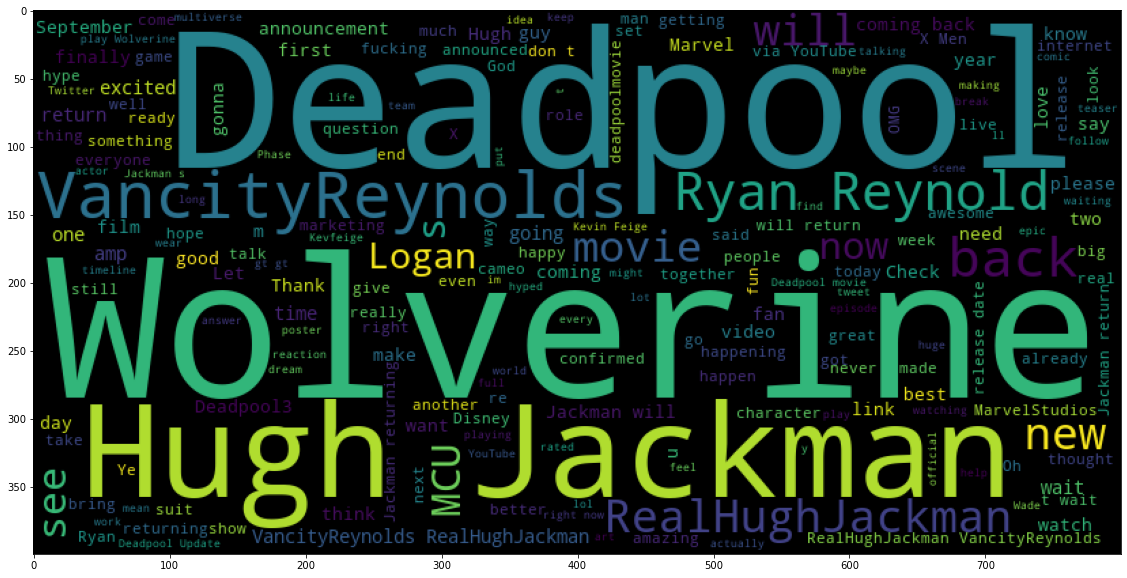

In [53]:
#Creating the wordcloud image and save it
wordcloud = WordCloud(width = 800, height = 400).generate(" ".join(words_no_h_l))

plt.figure(figsize = (20,10))
plt.imshow(wordcloud)
plt.axis("on")
plt.savefig('my_word_cloud.png')
plt.show()

## D.Sentiment Analysis

Before doing Step D, we want to remove hashtags and hyperlinks in the text. The hashtags and hyperlinks do not change the meaning of the Twitter text itself, but with them showing up in the text of our tweets dataset, there could be impacts on our result. 

For this time, the removal of hashtags and hyperlinks is slightly different from what we did in Step B. In order to do polarity and subjectivity analysis, we can no longer use the separate words, so after removing the hashtags and hyperlinks, we need to reassociate the words back to sentences.

We created a list of text of no hashtags as `txt_nohash`, then used the for loop function to fetch through all the tweets we have in text from our dataset. We used the split function to splits a string into a list of words, then made a copy of our original token to iterate on. This is to help us make sure to finish the task with the ability to keep track of our original data. After removing the # in tweets text, we appended the results back to our `txt_nohash` list. We followed the same method to remove the http in tweets text, and append the results to the same list, which is `txt_nohash`. (The difference between these two methods and the previous methods that also remove hyperlinks and hashtas is that, these two methods form the words back into a sentence; we need sentences to do the sentiment analysis, instead of just words in this case.)

**Notice** `txt_nohash` in both methods are temporary lists, meaning they will void out when the method is called and execute. 

In [54]:
#creating a method deleting # and hyperlink, and form them as sentences
def remove_hash(tweet_txt):
    txt_nohash = []
    for i in tweets_txt:
        tokens = i.split()
        tokens_val = tokens.copy()
        for i in tokens:
            if '#' in i:
                tokens_val.remove(i)
        txt_nohash.append(" ".join(tokens_val))
    return txt_nohash

def remove_link(tweet_txt):
    txt_nohash = []
    for i in tweets_txt:
        tokens = i.split()
        tokens_val = tokens.copy()
        for i in tokens:
            if 'http' in i:
                tokens_val.remove(i)
        txt_nohash.append(" ".join(tokens_val))
    return txt_nohash

After getting the twitter posts text, we removed the hashtags and hyperlinks in the text and formed them back into sentences to get a list of tweets. 

In [55]:
#Getting a list of tweets text and remove all hashtags and form them as sentences
tweets_txt = []
for i in tweets:
    tweets_txt.append(i['text'])

tweet_txt = remove_link(remove_hash(tweets_txt))
tweet_txt[0:5]

['Ok so I have a new theory, we have vigalante shit and anti hero…. Tay is friends with Ryan Reynolds and deadpool 3 is coming out…. I’m thinking Taylor is either gonna be in it or music featured in it…. @taylorswift13 @taylornation13 @VancityReynolds #Deadpool3 #Midnights',
 '@CarefreHedonist Yes Deadpool 3 is happening with Wolverine!!!! #Deadpool3',
 "@VancityReynolds Seriously...I'm so excited for DEADPOOL 3. @RealHughJackman #Deadpool3 #RyanReynolds #Wolverine #HughJackman",
 '#Deadpool3 Deadpool 3 release date and return of wolverine -',
 'In our latest episode we talk about our GotY so far and the games still to come in 2023. We also discuss #Stadia shutdown, #RTX4000 series, and Hugh Jackman returning as Wolverine in #Deadpool3']

For the sentiment analysis, we first created 2 empty lists for storing the polarity and subjectivity information. Then, by defining two methods below, which take text as import and append their polarity and subjectivity into the lists we created, we passed the twitter text and get their polarity and subjectivity.

In [56]:
#Sentiment analysis
polarity = []
subjectivity = []
def getPolarity(tb):
    polarity.append(TextBlob(tb).sentiment.polarity)
def getSubj(tb):
    subjectivity.append(TextBlob(tb).sentiment.subjectivity)

for txt in tweets_txt:
    getPolarity(txt)
    getSubj(txt)

**1. What are the average polarity and subjectivity scores?**

For the average polarity and subjectivity scores, we wanted to create a data frame to contain the list of polarity and the list of subjectivity so we can get the statistical summary as well as graphing them. We named the dataframe as `ave_pol_sub`, and had one columns for polarity, another column for subjectivity.

In [57]:
#Average polarity and subjectivity
ave_pol_sub = pd.DataFrame(list(zip(polarity, subjectivity)), columns = ['Polarity', 'Subjectivity'])
ave_pol_sub.mean()

Polarity        0.138401
Subjectivity    0.327831
dtype: float64

Here we created a scatterplot using `hist` function, based on the data frame of our polarity and subjectivity dataset. We found that there is a significant amount of tweets have polarity close to 0 and subjectivity close to 0.

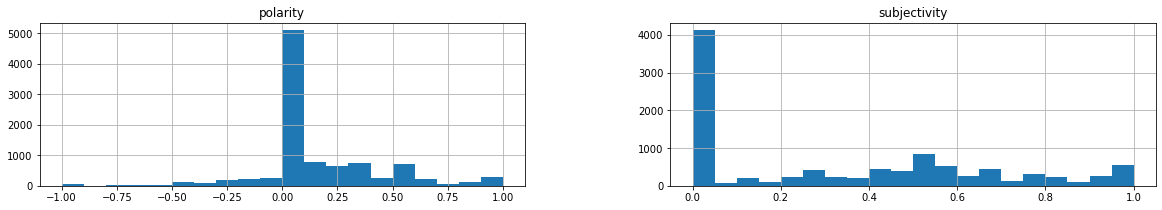

In [58]:
#Scatterplot
df = pd.DataFrame(list(zip(polarity,subjectivity)),columns = ('polarity', 'subjectivity'))
hist = df.hist(bins = 20)

In order to get the most and least polarity scores. we used `sort_value` to sort the polarity score, and presented them with the top and bottom three polarity scores in text.

In [59]:
#get most and least polarity score
df['txt'] = tweets_txt
df = df.sort_values(by = ['polarity'])
print(df)
bot = df.iloc[:3]['txt'].tolist()
top = df.iloc[-3:]['txt'].tolist()

      polarity  subjectivity  \
5150      -1.0           1.0   
5459      -1.0           0.8   
1365      -1.0           1.0   
8092      -1.0           0.8   
5676      -1.0           1.0   
...        ...           ...   
3735       1.0           0.3   
5621       1.0           1.0   
5616       1.0           1.0   
7878       1.0           1.0   
9378       1.0           1.0   

                                                    txt  
5150  This is truly evil. They explain how Wolverine...  
5459  LET'S FUCKING GOOOOOOOOOOOO!!!!!!!!!\n\n#Deadp...  
1365  The worst part about Hugh coming to #Deadpool3...  
8092  Hell fucking yes!!!!!!\nLet's go, merc with a ...  
5676  This is about to be insane #Deadpool3 https://...  
...                                                 ...  
3735  The two #Deadpool3 update vids are the best ma...  
5621  This is awesome #Deadpool3 https://t.co/ydwV4O...  
5616  The Marketing For this Film is already perfect...  
7878  ❤️❤️❤️❤️❤️❤️\n\n#Deadpool #De

In order to do our analysis and come to a conclusion, we used the for loop and print function to show the top three and bottom three polarity tweets. This helped us to analyze how individuals are expressing their actual thought on Deadpool 3.

In [60]:
#Printing out the top 3 polarity tweets
for i in top:
    print(i)

The Marketing For this Film is already perfect and they haven't even started yet!!!👏🤣⚔️ #DeadPool3 #Wolverine https://t.co/PpN4w4BqRy
❤️❤️❤️❤️❤️❤️

#Deadpool #Deadpool3 (Everything about this is perfect!)

❤️❤️❤️❤️❤️❤️ https://t.co/1HqKrDfuzk
Deadpool 3 about to be the greatest movie of 2024
#Deadpool3 https://t.co/8QE8iElw51


In [61]:
#Printing out the bottom 3 polarity tweets
for i in bot:
    print(i)

This is truly evil. They explain how Wolverine will be in #Deadpool3  https://t.co/X5bxsy8ciZ
LET'S FUCKING GOOOOOOOOOOOO!!!!!!!!!

#Deadpool3 #Wolverine https://t.co/8Fqx9eRBNn
The worst part about Hugh coming to #Deadpool3 is that we have to wait even longer for this. Shame 😔 https://t.co/ErroKLCSMu


Based on the above results, our conclusions are : 

Tweets with the highest polarity scores complimented Deadpool3 and are very excited about the film in 2024.
As the sentiment analysis package is not as smart as our human beings, the pakacge cannot understand sarcasm expressions. Therefore, Even in the bottle 3 polarity tweets, people are still excited about the upcoming Deadpool3 with Hugh playing as Wolverine. 

## E. Insights

#### 1. Insights gained from the analysis.

* Hugh Jackman returns 

From the word clouds we created earlier in Step C, we could see the news of Hugh Jackman returns to Marvel as Wolverine being one of the biggest ones to pop out.

* People excited about Hugh plays with Ryan 

With the results of our polarity test being larger than 0, it means that more Marvel audiences on Twitter generally have a positive perspective for Hugh to play with Ryan, they may not be subjective though.

* The usage of word cloud

We foud that wordclouds is helpful to support our conclusion 1 and conclusion 2 above, as some most common words in the graph include Wolver (which is the role Hugh Jackman plays in the moviw) and Ryan (which is the actor who plays Deadpool). 


* Limitation of subjectivity and polarity analysis

However, we also found that TextBlob is not that ‘smart’ to analyze everything, it is still too mechanized to analyze human's expression with emotions (such as sarcasm). Therefore, the polarity and subjectivity (what we did in the sentiment analysis) could be not inaccurate.

#### 2. Possible broader social media projects

Our plan is to do a project in analyzing whether or not specific users are paid posters for a specific video/post/event/news.

We can first collect comments from social media and divide them by posts/videos/events etc. Then, we do sentiment analysis over all the comments, and based on the polarity and subjectivity of the comments, we divide the authors into different clusters. This step is to see what kind of people these authors are to analyze their habits in commenting online; whether they are hate speech comment producers or they are more neutral.

Then, we analyze each individual cluster. We collect these authors' recent shares, thumbs up, comments, and history in different clusters. The purpose is to analyze their mental status, interest in topics, common polarity, and subjectivity scores, and to see if they are paying attention to this specific topic over a period of time instead of just a one-time comment. 
The mental status of the author can be reflected by the attitude in their recent comments or their recent focus. For example, if a user was view videos like cute cats a week ago and now is viewing videos including animal abuse, then there is definitely something wrong with the user. 

Analyzing the interesting topic can reflect if they really care about the topic of this event is related. For example, if the user never views celebrities or singers and, all of a sudden posts some hate speech over one specific celebrity, then there could be something wrong.
The polarity and subjectivity of their past comments can reflect which kind of commentators they were. Comparing their polarity and subjectivity record to the score they have for this event can see if the comment contradicts their normal comment style.

Finally, their history can reflect whether or not they have been viewing this topic. If they are interested in such an event, then they will be viewing more videos or posts. Then their comment will be valid in such cases.